# MNIST dataset with Keras
This notebooks is an excercise from 10th chapter regarding the book Hands on Machine Learning.

In [1]:
import numpy as np
import os

%matplotlib inline
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

Lets load the set:

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
print(X_train.dtype) # unsigned int for intensity of pixel
(X_train.min(), X_train.max()), (X_test.min(), X_test.max()), (y_train.min(), y_train.max(), y_test.min(), y_test.max())

uint8


((0, 255), (0, 255), (0, 9, 0, 9))

As we can see, the data is ranging from 0 to 255, and it represents intensity. we can change that by just dividing by maximum value and hence scaling between 0 and 1.

In [5]:
X_train=X_train.astype('float_')/255.0
X_test=X_test.astype('float_')/255.0

In [6]:
60000/70000*100, 10000/70000*100

(85.71428571428571, 14.285714285714285)

In train there are 6000 pictures each 28x28. In test there are 10000 pictures with same size, hence the sizes are around 86% and 14% accordingly, but the samples are large enough.

5


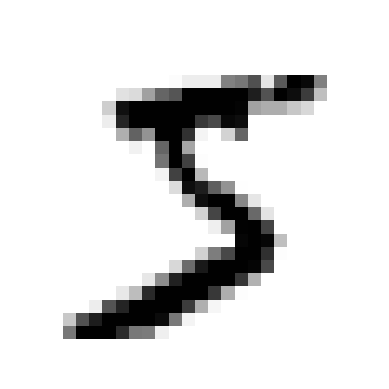

In [7]:
print(y_train[0])
plt.axis('off')
plt.imshow(X_train[0], cmap='binary')
plt.show()

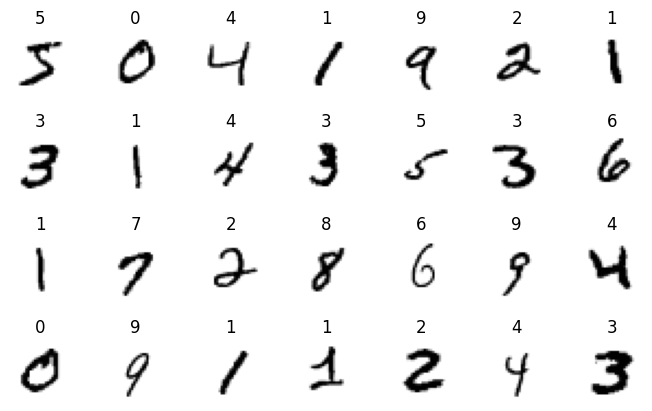

In [8]:
n_rows = 4
n_cols = 7
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for col in range(n_cols):
    for row in range(n_rows):
        index = n_cols*row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(X_train[index], cmap='binary')
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(hspace=.7)
plt.show()


This can give us some idea how the dataset looks like.

# Simple dense model building using Sequential API

Let's make a callback that will allow us to track down how the losses behave regarding learning rate.

In [9]:
class LearningRateCallback(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs=None):
        self.rates.append(keras.backend.get_value(self.model.optimizer.learning_rate)) # getting learning rate and appending the array
        self.losses.append(logs['loss'])
        keras.backend.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor) # setting new learning rate
keras.backend.clear_session()

Now simple model using Sequential API

In [10]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [11]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=['accuracy'])
lr = LearningRateCallback(1.005)

In [13]:
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    callbacks=[lr])

1688/1688 [==============================] - 7s 4ms/step - loss: 43160481216085771681792.0000 - accuracy: 0.5976 - val_loss: 2.3991 - val_accuracy: 0.0952


Text(0, 0.5, 'Loss')

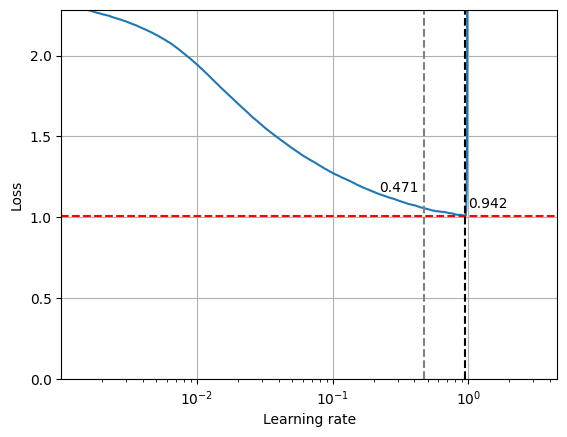

In [94]:
plt.plot(lr.rates, lr.losses)
plt.gca().set_xscale('log')
# horizontal red line
plt.hlines(min(lr.losses), min(lr.rates), max(lr.rates), linestyles="dashed", colors='red')
# black line
plt.annotate(xy=(lr.rates[np.array(lr.losses).argmin()]+0.05, min(lr.losses)+0.05), text='{0:.3f}'.format(lr.rates[np.array(lr.losses).argmin()]))
plt.vlines(lr.rates[np.array(lr.losses).argmin()], 0, max(lr.losses), linestyles='dashed', colors='black')
# gray line
tuner_lr = lr.rates[np.array(lr.losses).argmin()]/2
plt.annotate(xy=(tuner_lr-0.25, min(lr.losses)+0.15), text='{0:.3f}'.format(tuner_lr))
plt.vlines(tuner_lr, 0, max(lr.losses), linestyles='dashed', colors='gray')

plt.axis([min(lr.rates), max(lr.rates), 0, lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

Seing that around 0.942 learning rate is right before the moment of loosing a gradient, following the presuppositional that the half is around optimal most of the time we can stick with that and assume that 0.471 is a fine number.

In [95]:
keras.backend.clear_session()
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=tuner_lr),
              metrics=["accuracy"])

In [99]:
run_logdir = os.path.join(os.curdir, "mlp_mnist_logs")
run_logdir

def get_run_logdir(name, dir=None):
    import time
    if dir is None:
        run_id = time.strftime(f"{name}/run_%Y_%m_%d-%H_%M_%S")
    else:
        run_id = time.strftime(f"{dir}/{name}/run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(run_logdir, run_id)

def get_log_tfb_callback(name, dir=None):
    return keras.callbacks.TensorBoard(get_run_logdir(name, dir))

In [104]:
keras.backend.clear_session()
history = model.fit(X_train, y_train, epochs=100,
                    validation_split=0.1,
                    callbacks=[
                        keras.callbacks.EarlyStopping(patience=15),
                        get_log_tfb_callback("mlp_mnist_model"),
                        keras.callbacks.ModelCheckpoint("mlp_mnist_model.h5", save_best_only=True)
                    ])

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0802 - accuracy: 0.9752 - val_loss: 0.1333 - val_accuracy: 0.9668
Epoch 2/100
  34/1688 [..............................] - ETA: 5s - loss: 0.0497 - accuracy: 0.9835

c:\Users\juziu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1688/1688 [==============================] - 6s 4ms/step - loss: 0.0624 - accuracy: 0.9803 - val_loss: 0.3236 - val_accuracy: 0.9268
Epoch 3/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0477 - accuracy: 0.9849 - val_loss: 0.0651 - val_accuracy: 0.9823
Epoch 4/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0394 - accuracy: 0.9875 - val_loss: 0.0710 - val_accuracy: 0.9785
Epoch 5/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0318 - accuracy: 0.9900 - val_loss: 0.0893 - val_accuracy: 0.9787
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0260 - accuracy: 0.9919 - val_loss: 0.0866 - val_accuracy: 0.9782
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0265 - accuracy: 0.9915 - val_loss: 0.1457 - val_accuracy: 0.9698
Epoch 8/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0311 - accuracy: 0.9904 - val_loss: 0.1028 - val_accuracy: 0.97

In [105]:
model = keras.models.load_model('mlp_mnist_model.h5')
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0822 - accuracy: 0.9768


[0.08222375810146332, 0.9768000245094299]

Quite nice, however that is not above 98% accuracy, hence let's tune some hyperparameters.

# Hyperparameter tuning
Let's try using keras tuner.

In [142]:
import keras_tuner as kt
# model builder function
def model_builder(hp: kt.HyperParameters):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28,28]))

    # First layer number of neurons
    hp_units = hp.Int('units', min_value=30, max_value=480, step=30) # 15
    hp_hidden_units = hp.Int('hidden_units', min_value=10, max_value=60, step=10) # 6
    hp_hidden_layers = hp.Int('no_layers', min_value=0, max_value=3, step=1) # 3
    hp_activation = hp.Choice('activation', values=['relu', 'tanh']) # 2
    # 540

    model.add(keras.layers.Dense(units=hp_units, activation=hp_activation))
    for layer in range(hp_hidden_layers):
        model.add(keras.layers.Dense(units=hp_hidden_units, activation=hp_activation))
    
    # Learning rate is set, however we will check around the value we got
    hp_learning_rate = hp.Choice('learning_rate', values=(np.linspace(tuner_lr-.15, tuner_lr+.15, num=8)).tolist()) # 8
    hp_optimizer = hp.Choice('optimizer',
                             values=[
                                 'keras.optimizers.SGD(learning_rate=hp_learning_rate)',
                                 'keras.optimizers.Adam(learning_rate=hp_learning_rate)']) # 2
    
    # 16
    # 8 640 combinations as a whole
    model.compile(optimizer=eval(hp_optimizer),
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model

In [144]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     overwrite=True,
                     max_epochs=12,
                     directory='mnist_hyperband',
                     project_name='mlp_minst')

In [145]:
tuner.search(X_train, y_train,
             epochs=50,
             validation_split=0.1,
             callbacks=[
                 get_log_tfb_callback("mlp_mnist_model_tuned"),
                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
             ])

Trial 30 Complete [00h 01m 15s]
val_accuracy: 0.972000002861023

Best val_accuracy So Far: 0.984333336353302
Total elapsed time: 00h 19m 43s
INFO:tensorflow:Oracle triggered exit


In [153]:
tuner.results_summary(num_trials=1)

Results summary
Results in mnist_hyperband\mlp_minst
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 0024 summary
Hyperparameters:
units: 180
hidden_units: 30
no_layers: 1
activation: relu
learning_rate: 0.44951598218509126
optimizer: keras.optimizers.SGD(learning_rate=hp_learning_rate)
tuner/epochs: 12
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0023
Score: 0.984333336353302


This looks very promising, as 98.43% of accuracy achieves a goal of 98%. Let's train whole model again on these parameters and test results.

In [154]:
model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
history = model.fit(X_train, y_train, epochs=100,
                    validation_split=0.1,
                    callbacks=[
                        keras.callbacks.EarlyStopping(patience=15),
                        get_log_tfb_callback("mlp_mnist_model"),
                        keras.callbacks.ModelCheckpoint("mlp_mnist_model.h5", save_best_only=True)
                    ])

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2452 - accuracy: 0.9254 - val_loss: 0.2802 - val_accuracy: 0.9232
Epoch 2/100
  52/1688 [..............................] - ETA: 4s - loss: 0.1434 - accuracy: 0.9579

c:\Users\juziu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1688/1688 [==============================] - 5s 3ms/step - loss: 0.0984 - accuracy: 0.9691 - val_loss: 0.0912 - val_accuracy: 0.9757
Epoch 3/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0694 - accuracy: 0.9779 - val_loss: 0.1741 - val_accuracy: 0.9483
Epoch 4/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0539 - accuracy: 0.9836 - val_loss: 0.0796 - val_accuracy: 0.9797
Epoch 5/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0388 - accuracy: 0.9871 - val_loss: 0.0832 - val_accuracy: 0.9792
Epoch 6/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0310 - accuracy: 0.9896 - val_loss: 0.0768 - val_accuracy: 0.9798
Epoch 7/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0223 - accuracy: 0.9925 - val_loss: 0.0771 - val_accuracy: 0.9795
Epoch 8/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0177 - accuracy: 0.9941 - val_loss: 0.0838 - val_accuracy: 0.97

In [155]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 180)               141300    
                                                                 
 dense_3 (Dense)             (None, 30)                5430      
                                                                 
Total params: 146730 (573.16 KB)
Trainable params: 146730 (573.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [156]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0802 - accuracy: 0.9836


[0.08021683990955353, 0.9836000204086304]

Very nice.